<br>
<br>
<br>
<font size=6>Метод K Nearest Neighbors</font><br>
<br>
Метод ближайших соседей - алгоритм классификации.
<br>
<br>
<br>

Для <b>классификации</b> каждого из объектов тестовой выборки необходимо выполнить следующие операции:

- Вычислить расстояние до каждого из объектов обучающей выборки.
- Отобрать <i><b>k</b></i> объектов обучающей выборки, расстояние до которых минимально.
- Класс классифируемого объекта - это класс, наиболее часто встречающийся среди <i><b>k</b></i> ближайших соседей.

<br>
Под задачу <b>регрессии</b> - на 3 шаге возвращается не метка, а число - среднее (или медианное) значение целевого признака среди соседей.
<br>

Интересное свойство такого подхода - <i>ленивость</i>.<br>
Дело в том, что вычисления начинаются только в момент классификации тестового примера, а заранее никакя модель не строится.

Авторы классической книги "The Elements of Statistical Learning" считают kNN теоретически идеальным алгоритмом, применимость которого просто ограничена вычислительными возможностями и проклятием размерностей.

<br>
<font size=3><b>Метод ближайших соседей в реальных задачах</b></font>:
<br><br>

 - В чистом виде kNN может послужить хорошим стартом (baseline) в решении какой-либо задачи;
 - В соревнованиях Kaggle kNN часто используется для построения мета-признаков (прогноз kNN подается на вход прочим моделям) или в стекинге/блендинге;
 - Идея ближайшего соседа расширяется и на другие задачи, например, в рекомендательных системах простым начальным решением может быть рекомендация какого-то товара (или услуги), популярного среди ближайших соседей человека, которому хотим сделать рекомендацию;
 - На практике для больших выборок часто пользуются приближенными методами поиска ближайших соседей
 
 <br>

<br>
<font size=3><b>Качество классификации/регрессии методом ближайших соседей зависит от нескольких параметров</b></font>:
<br><br>

 - число соседей
 - метрика расстояния между объектами (часто используются метрика Хэмминга, евклидово расстояние, косинусное расстояние и расстояние Минковского). Отметим, что  - при использовании большинства метрик значения признаков надо масштабировать. Условно говоря, чтобы признак "Зарплата" с диапазоном значений до 100 тысяч не   вносил больший вклад в расстояние, чем "Возраст" со значениями до 100.
 - веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос")

<br>

<br>
<font size=4>KNeighborsClassifier в Scikit-learn</font>
<hr>
Основные параметры класса sklearn.neighbors.KNeighborsClassifier:

 - <b>weights</b>: "uniform" (все веса равны), "distance" (вес обратно пропорционален расстоянию до тестового примера) или другая определенная пользователем функция.
 - <b>algorithm</b> (опционально): "brute", "ball_tree", "KD_tree" или "auto". В первом случае ближайшие соседи для каждого тестового примера считаются перебором обучающей выборки. Во втором и третьем - расстояние между примерами хранятся в дереве, что ускоряет нахождение ближайших соседей. В случае указания параметра 'auto' подходящий способ нахождения соседей будет выбран автоматически на основе обучающей выборки.
 - <b>leaf_size</b> (опционально): Порог переключения на полный перебор в случае выбора BallTree или KDTree для нахождения соседей
 - <b>metric</b>: "minkowski", "manhattan", "euclidean", "chebyshev" и другие.

<br>
<font size=4>Пример применения</font>
<br>
<br>


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score

In [2]:
data = pd.read_csv('data/telecom_churn.csv')
data.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [3]:
data['International plan'] = pd.factorize(data['International plan'])[0]
data['Voice mail plan'] = pd.factorize(data['Voice mail plan'])[0]
data['Churn'] = data['Churn'].astype('int')
states = data['State']
y = data['Churn']
data.drop(['State', 'Churn'], axis=1, inplace=True)
data.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,117,408,0,0,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1
1,65,415,0,0,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4
2,161,415,0,0,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4
3,111,415,0,0,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2
4,49,510,0,0,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1


In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, y, train_size=0.7, random_state=17)

tree = DecisionTreeClassifier(max_depth=6, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)
knn.fit(X_train, y_train)

tree_pred = tree.predict(X_test)
knn_pred = knn.predict(X_test)

print(f'Accuracy tree: {accuracy_score(tree_pred, y_test)}')
print(f'Accuracy knn: {accuracy_score(knn_pred, y_test)}')

Accuracy tree: 0.9253731343283582
Accuracy knn: 0.8557213930348259


Настройка параметров модели

In [14]:
tree_params = {
    'max_depth': range(1, 11),
    'max_features': range(4, 19)
}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)
print(f'Лучшее сочетание параметров: {tree_grid.best_params_}')
print(f'Accuracy = {accuracy_score(tree_grid.predict(X_test), y_test)}')

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Лучшее сочетание параметров: {'max_depth': 5, 'max_features': 12}
Accuracy = 0.9104477611940298


In [24]:
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

knn_params = {
    'knn__n_neighbors': range(1, 15),
}

knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)
knn_grid.fit(X_train, y_train)
print(f'Лучшее сочетание параметров: {knn_grid.best_params_}')
print(f'Accuracy knn = {accuracy_score(knn_grid.predict(X_test), y_test)}')

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Лучшее сочетание параметров: {'knn__n_neighbors': 7}
Accuracy knn = 0.8606965174129353


Экспорт дерева в png

In [32]:
export_graphviz(tree_grid.best_estimator_, feature_names=data.columns, out_file='churn_tree.dot', filled=True)
!dot -Tpng 'churn_tree.dot' -o 'churn_tree.png'

<br>
<font size=4>Сложный случай для KNN</font>
<br><br>

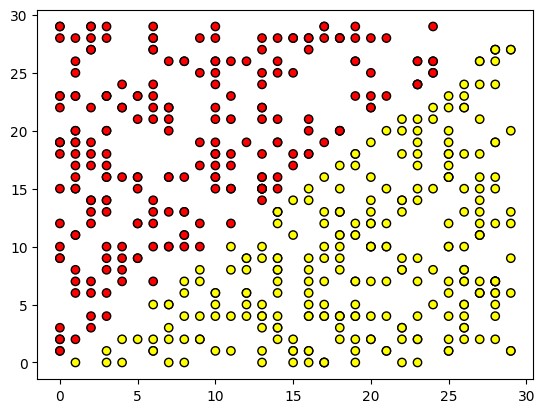

In [35]:
def from_linearly_separable_data(n=500, x1_min=0, x1_max=30, x2_min=0, x2_max=30):
    data, target = [], []
    for i in range(n):
        x1, x2 = np.random.randint(x1_min, x1_max), np.random.randint(x2_min, x2_max)
        if np.abs(x1 - x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1 - x2))
    return np.array(data), np.array(target)
      
X, y = from_linearly_separable_data()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolors='black')

In [38]:
def get_grid(data):
    xx, yy = np.meshgrid(np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), 500),
                         np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), 500))
    return xx, yy

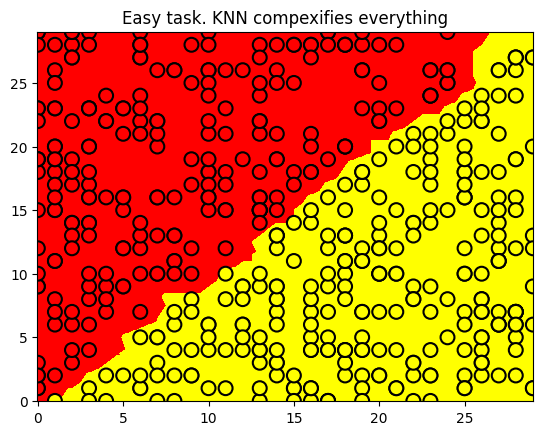

In [40]:
tree = KNeighborsClassifier(n_neighbors=2).fit(X, y)

xx, yy = get_grid(X)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100,
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.title("Easy task. KNN compexifies everything")
plt.show()

<br>
<font size=5>Плюсы и минусы метода ближайших соседей</font>
<hr>
<br>
<b>Плюсы:</b>

 - Простая реализация
 - Неплохо изучен теоретически
 - Как правило, метод хорошо для первого решения задачи, причем не только классификации или регрессии,но и, например, рекомендации
 - Можно адаптировать под нужную задачу выбором метрики или ядра (в двух словах: ядро может задавать операцию сходства для сложных объектов типа графов)
 - Неплохая интерпретация, можно объяснить почему тестовый пример был классифицирован именно так. Хотя этот аргумент можно атаковать: если число соседей большое, то интерпретация ухудшается (условно: "мы не дали ему кредит, потому что он похож на 350 клиентов, из которых 70 - плохие, что на 12% больше, чем в среднем по выборке).
<br><br>

<b>Минусы:</b>

 - Метод считается быстрым в сравнении, например, с композициями алгоритмов, но в реальных задачах, как правило, число соседей, используемых для классификации, будет большим (100-150), и в таком случае алгоритм будет работать не так быстро, как дерево решений.
 - Если в наборе данных много признаков, то трудно подобрать подходящие веса и определить, какие признаки не важны для классификации/регрессии.
 - Зависимость от выбранной метрики расстояния между примерами.Выбор по умолчанию евклидового расстояния чаще всего ничем не обоснован. Можно отыскать хорошее решение перебором параметров, но для большого набора данных это отнимает много времени.
 - Нет теоретических оснований выбора определенного числа соседей — только перебор (впрочем, чаще всего это верно для всех гиперпараметров всех моделей). В случае малого числа соседей метод чувствителен к выбросам, то есть склонен переобучаться;
 - Как правило, плохо работает, когда признаков много, из-за "прояклятия размерности". Про это хорошо рассказывает известный в ML-сообществе профессор Pedro Domingos – тут в популярной статье "A Few Useful Things to Know about Machine Learning", также "the curse of dimensionality" описывается в книге Deep Learning в главе "Machine Learning basics".
<br><br>